## Local ADCP Particle test with CMEMS data

### Compute distance travelled by ship

In [2]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

### Read sample input data

In [7]:
from datetime import timedelta
import numpy as np
import math

from parcels import (
    AdvectionRK4,
    ErrorCode,
    Field,
    FieldSet,
    JITParticle,
    ScipyParticle,
    ParticleSet,
    Variable,
)

In [75]:
# Load the CMEMS data (3 days manually downloaded)
example_dataset_folder = "../Data"
filenames = {
    "U": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "Usample": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "V": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "Vsample": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "S": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-so_hcst_R20210113.nc",
    "T": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-thetao_hcst_R20210113.nc"}
variables = {'U': 'uo', 'Usample': 'uo', 'V': 'vo', 'Vsample': 'vo', 'S':'so', 'T':'thetao'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time', 'depth':'depth'}

# create the fieldset and set interpolation methods
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, time_periodic=timedelta(days=3))
fieldset.T.interp_method = "linear_invdist_land_tracer"
fieldset.S.interp_method = "linear_invdist_land_tracer"

# determine top and bottom layer in the hydrodynamic data
fieldset.mindepth = math.ceil(fieldset.U.depth[0])
fieldset.maxdepth = math.floor(fieldset.U.depth[-1])
# TODO replace by bathymetry data
bathymetry_file = f"{example_dataset_folder}/GLO-MFC_001_024_mask_bathy.nc"
bathymetry_variables = ('bathymetry', 'deptho')
bathymetry_dimensions = {'lon': 'longitude', 'lat': 'latitude'}
bathymetry_field = Field.from_netcdf(bathymetry_file, bathymetry_variables, bathymetry_dimensions)
fieldset.add_field(bathymetry_field) 
fieldset.add_constant('z_start',0.5)

# set initial location
coords = [[-5.888672, 48.516604], [-31.992188, 48.806863], [-31.992188, 45.521744], [-23.378906, 42.358544], [-12.304688, 42.423457]]
loc = 0
ini_lat = coords[loc][0]
ini_lon = coords[loc][1]


### Determine ship course and add as kernel 

In [23]:
# change advection to ship movement
# Cruising speed Pelagia (and Anna Weber) is 9 knp https://www.nioz.nl/application/files/3614/9744/8746/Pelagia_Technical_specifications-2016.pdf
# survey speed nog iets lager? Zoals bij https://schmidtocean.org/rv-falkor/ship-specifications/
# 7 knp = 13 km/h = 3.6 m/s

# TODO add coords to function
def ShipVel(particle, fieldset, time):
    # loc = 1
    speed = 3.6
    target_lat = -32 #coords[loc][0]
    target_lon = 49 #coords[loc][1]
    # # slow down when close to target
    # if target_lat - particle.lat < 3.6*3600/1.11e5 or target_lon - particle.lon < 3.6*3600/(1.11e5 * math.cos(particle.lat * math.pi / 180)):
    #     speed = speed/4
    # determine ship direction
    heading = math.sqrt((target_lat - particle.lat)**2 + (target_lon - particle.lon)**2)
    # calculate e/w and n/s speed (m/s)
    lat_add = (target_lat - particle.lat)/(heading/speed)
    lon_add = (target_lon - particle.lon)/(heading/speed)
    # convert to lat/lon
    lat_add_deg = lat_add / 1.11e5
    lon_add_deg = lon_add / (1.11e5 * math.cos(particle.lat * math.pi / 180))
    # add to particle position
    particle.lat += lat_add_deg * particle.dt
    particle.lon += lon_add_deg * particle.dt
    # update loc if close to target TODO target reached
    # if target_lat - particle.lat < 3.6*3600/1.11e5 or target_lon - particle.lon < 3.6*3600/(1.11e5 * math.cos(particle.lat * math.pi / 180)):
    #     loc += 1
    #     speed = 3.6

### Define particles and sampling functions 

In [76]:
# Create and initialize Variable particles to sample the ocean
class ADCPParticle(ScipyParticle):
    """Define a new particle class that does ADCP like measurements"""
    U = Variable('U', dtype=np.float32, initial=0.0)
    V = Variable('V', dtype=np.float32, initial=0.0)

# # define function sampling u and v as in https://docs.oceanparcels.org/en/latest/examples/tutorial_sampling.html
# def SampleVel_correct(particle, fieldset, time):
#     # Attention: samples particle velocity in units of the mesh (deg/s or m/s)
#     particle.U, particle.V = fieldset.UV[time, particle.depth, particle.lat, particle.lon, particle]

# define sampling function from Usample and Vsample (because of A grid)
def SampleVel(particle, fieldset, time):
    particle.U = fieldset.Usample[time, particle.depth, particle.lat, particle.lon]
    particle.V = fieldset.Vsample[time, particle.depth, particle.lat, particle.lon]

# Create and initialize Variable particles to sample the ocean
class CTDParticle(JITParticle):
    """Define a new particle class that does CTD like measurements""" 
    salinity = Variable("salinity", initial=np.nan)
    temperature = Variable("temperature", initial=np.nan)

# define function sampling Salinity 
def SampleS(particle, fieldset, time):
    particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]

# define function sampling Temperature 
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]

### Create a particle set and choose kernels

In [84]:
# ADCP like particle TODO accurate depths 
depthnum = 20
# Initiate ADCP like particle set 
pset = ParticleSet.from_list(
    fieldset=fieldset, pclass=ADCPParticle, lon=np.full(depthnum,ini_lon), lat=np.full(depthnum,ini_lat), depth=np.linspace(5, 1000, num=depthnum)
)

# Casting the ADCP sample function to a kernel
# SampleVel_kernel = pset.Kernel(SampleVel_correct)  
SampleVel_kernel = pset.Kernel(SampleVel)  

# Cast the ships velocity function to a kernel object
ShipVel_kernel = pset.Kernel(ShipVel)

# Choose which kernels to use
kernels = SampleVel_kernel + ShipVel_kernel 

### Run simulation

In [85]:
# write the particle data every hour
outputdt = timedelta(hours=1).total_seconds()

# release CTD every 6 hours
repeatdt = timedelta(hours=6).total_seconds()

# run the model for 24 hours
runtime = timedelta(hours=15).total_seconds()

# CTD stuff
# initialize CTD station number
station = 0
# Set max depth for CTD cast TODO max depth depending on bathymetry
CTD_depth = fieldset.maxdepth - fieldset.mindepth


# create a ParticleFile to store the output
# Note: Do not specify the outputdt yet, so we can manually write the output
output_file = pset.ParticleFile(name="ADCP_CTD_test.zarr")

for time in np.arange(0, runtime, outputdt):

    # check if time is a multiple of repeatdt
    # TODO add time and advection?
    if np.isclose(np.fmod(time, repeatdt), 0):
        station += 1
        # create a ParticleFile to store the CTD output
        ctd_output_file = pset.ParticleFile(name=f"CTD_test_{station}.zarr")

        cur_lon = pset.lon[0]
        cur_lat = pset.lat[0]
        # # TODO change depth to bathymetry data
        # print(fieldset.bathymetry[pset.time, pset.z_start, pset.lat, pset.lon])

        # release CTD particles
        pset_CTD = ParticleSet.from_list(
            fieldset=fieldset, 
            pclass=CTDParticle, 
            lon=np.full(CTD_depth,cur_lon), 
            lat=np.full(CTD_depth,cur_lat), 
            depth=np.linspace(fieldset.mindepth, fieldset.maxdepth, num=CTD_depth),
            time=time,
        )           
        # Casting the SampleS and T functions to kernels
        Sample_S_kernel = pset_CTD.Kernel(SampleS)  # Casting the SampleS function to a kernel
        Sample_T_kernel = pset_CTD.Kernel(SampleT)  # similar for temperature
        # Choose which kernels to use for CTD
        CTD_kernels = Sample_S_kernel + Sample_T_kernel
        # record the initial temperature of the particles
        pset_CTD.execute(CTD_kernels, dt=0)

        # write the CTD particles to the output file
        print("CTD time!")
        ctd_output_file.write(pset_CTD, time)

    # write the initialised particles and the advected particles
    output_file.write(pset, time)

    pset.execute(kernels, runtime=outputdt, dt=timedelta(minutes=60))
    # print(f"Writing time {time}")

output_file.write(pset, time + outputdt)

INFO: Compiled ArrayCTDParticleSampleSSampleT ==> /tmp/parcels-382783/libf32f51e5d8b5816e809f7e7382f8ab0a_0.so


CTD time!


INFO: Compiled ArrayCTDParticleSampleSSampleT ==> /tmp/parcels-382783/lib317a017a531a4e3d373c760b89ebbe2c_0.so


CTD time!


INFO: Compiled ArrayCTDParticleSampleSSampleT ==> /tmp/parcels-382783/libd0bb4dffffb209e8763d3abe30a6d0e7_0.so


CTD time!


In [92]:
import xarray as xr
# Open and combine the output files
da = xr.open_zarr("CTD_test_1.zarr")
for i in range(2, station+1):
    da = xr.concat([da, xr.open_zarr(f"CTD_test_{i}.zarr")], "obs")
# Write the combined output to a netcdf file
da.to_netcdf("CTD_test.nc", mode="w")
da.close()

PermissionError: [Errno 13] Permission denied: '/storage/home/0448257/Virtual_ship_classroom/CTD_test.nc'

### Do some plotting to check output

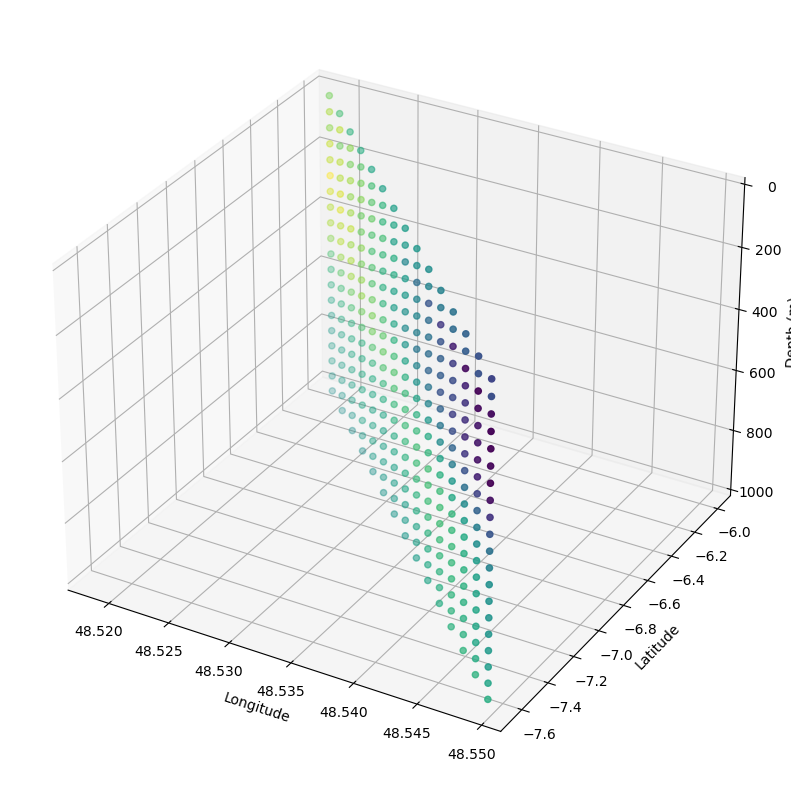

In [87]:
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

# Open output and read to x, y, z
ds = xr.open_zarr("ADCP_CTD_test.zarr")
# ds = xr.open_zarr('tmp.zarr')
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
U = ds["U"][:].squeeze()
V = ds["V"][:].squeeze()
# salinity = ds["salinity"][:].squeeze()
# temperature = ds["temperature"][:].squeeze()
ds.close()

# Plot Particle depth
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=V, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

### Plot CTD casts

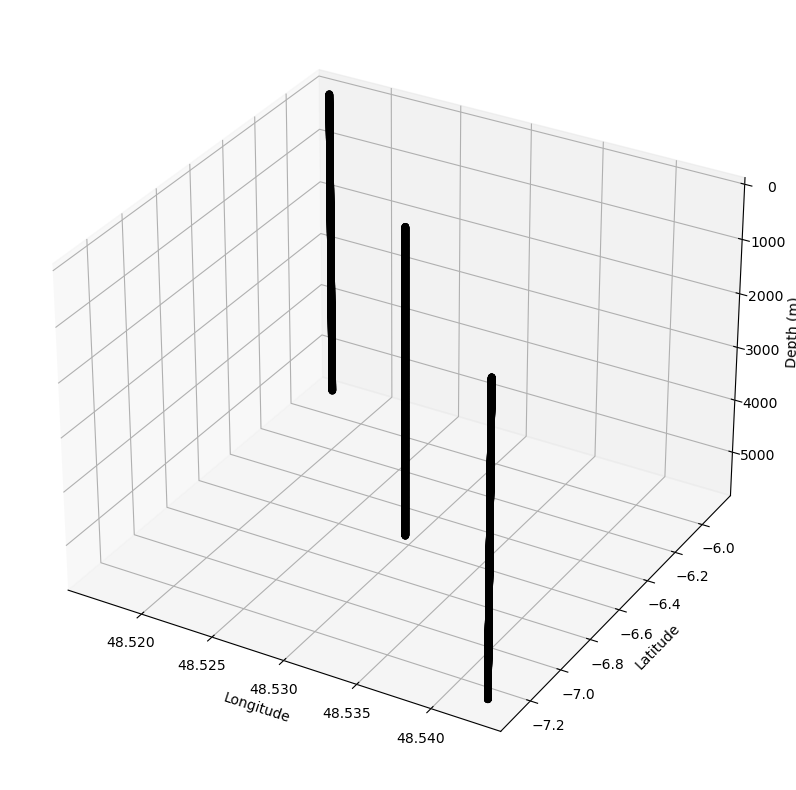

In [88]:
# Open output and read to x, y, z
ds = xr.open_dataset("CTD_test.nc")
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
U = ds["U"][:].squeeze()
V = ds["V"][:].squeeze()
# salinity = ds["salinity"][:].squeeze()
# temperature = ds["temperature"][:].squeeze()
ds.close()

# Plot Particle depth
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=U, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

In [89]:
# Open and combine the output files
da = xr.open_zarr("CTD_test_1.zarr")
print(da)
da.close()


<xarray.Dataset>
Dimensions:     (trajectory: 5726, obs: 1)
Coordinates:
  * obs         (obs) int32 0
  * trajectory  (trajectory) int64 80344 80345 80346 80347 ... 86067 86068 86069
Data variables:
    U           (trajectory, obs) float32 dask.array<chunksize=(5726, 1), meta=np.ndarray>
    V           (trajectory, obs) float32 dask.array<chunksize=(5726, 1), meta=np.ndarray>
    lat         (trajectory, obs) float32 dask.array<chunksize=(5726, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(5726, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(5726, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(5726, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.2
